In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import issparse

# Load data
df = pd.read_csv('text_preprocessing/final_dataset.csv')

In [43]:
# Convert sentiment labels to binary
def convert_label_sentimen(label_sentimen):
    return 1 if label_sentimen == "positive" else 0

df['label_sentimen'] = df['Sentiment'].apply(convert_label_sentimen)
df.drop(df.columns[[0]], axis=1, inplace=True)
X = df['tweet_tokens_stemmed'] 
y = df['label_sentimen']

In [44]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
class NaiveBayes:
    def __init__(self, model_class):
        self.model_class = model_class
        self.clf = None
    
    def fit(self, X_train, y_train, selected_features):
        self.clf = self.model_class()
        if issparse(X_train):
            X_train = X_train.toarray()
        self.clf.fit(X_train[:, selected_features], y_train)
    
    def predict(self, X_test, selected_features):
        if self.clf is None:
            raise ValueError("Classifier not fitted. Please call 'fit' method first.")
        if issparse(X_test):
            X_test = X_test.toarray()
        return self.clf.predict(X_test[:, selected_features])


In [51]:
def evaluate_features(X_train, y_train, selected_features, classifier):
    classifier.fit(X_train, y_train, selected_features)
    return classifier.clf.score(X_train[:, selected_features], y_train)

def pso_feature_selection(X_train, y_train, n_particles, inertia, global_weight, local_weight, model_class, tol=1e-5, patience=10):
    num_samples, num_features = X_train.shape
    bounds = [0, 1]
    
    particles = np.random.rand(n_particles, num_features)
    velocities = np.random.rand(n_particles, num_features) * 0.1
    best_positions = particles.copy()
    best_scores = np.zeros(n_particles)

    global_best_position = np.zeros(num_features)
    global_best_score = 0

    no_improvement_count = 0
    previous_global_best_score = 0

    while no_improvement_count < patience:
        for particle in range(n_particles):
            r1 = np.random.rand(num_features)
            r2 = np.random.rand(num_features)
            velocities[particle] = (inertia * velocities[particle] +
                                    global_weight * r1 * (best_positions[particle] - particles[particle]) +
                                    local_weight * r2 * (global_best_position - particles[particle]))

            particles[particle] += velocities[particle]
            particles[particle] = np.clip(particles[particle], bounds[0], bounds[1])

            selected_features = particles[particle] > 0.5
            nb = NaiveBayes(model_class)
            accuracy = evaluate_features(X_train, y_train, selected_features, nb)

            if accuracy > best_scores[particle]:
                best_scores[particle] = accuracy
                best_positions[particle] = particles[particle].copy()

            if accuracy > global_best_score:
                global_best_score = accuracy
                global_best_position = particles[particle].copy()

        if abs(global_best_score - previous_global_best_score) < tol:
            no_improvement_count += 1
        else:
            no_improvement_count = 0
        
        previous_global_best_score = global_best_score

    return global_best_position > 0.5


In [54]:
# Define parameters for PSO optimization
population_size_range = [5 * (2 ** i) for i in range(5)]  # 5, 10, 20, 40, 80
inertia = 0.6
global_weight = 0.3
local_weight = 0.6

results = []

tfidf_model = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tfidf_model.fit_transform(X_train)
X_test_tfidf = tfidf_model.transform(X_test)

X_train_dense = X_train_tfidf.toarray()

for n_particles in population_size_range:
    selected_features = pso_feature_selection(X_train_dense, y_train, n_particles, inertia, global_weight, local_weight, MultinomialNB)

    if not np.any(selected_features):
        selected_features[0] = True

    nb = NaiveBayes(MultinomialNB)
    nb.fit(X_train_tfidf, y_train, selected_features)
    y_pred = nb.predict(X_test_tfidf.toarray(), selected_features)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    fold_results = {
        "Population Size": n_particles,
        "Average Accuracy": accuracy,
        "Average Precision": precision,
        "Average Recall": recall
    }

    results.append(fold_results)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Population Size", "Average Accuracy"], ascending=[True, False])

print(results_df.to_string(index=False))
results_df.to_csv("population_size.csv")


 Population Size  Average Accuracy  Average Precision  Average Recall
               5            0.7750           0.805556           0.725
              10            0.8625           0.837209           0.900
              20            0.8750           0.857143           0.900
              40            0.8250           0.825000           0.825
              80            0.8875           0.878049           0.900


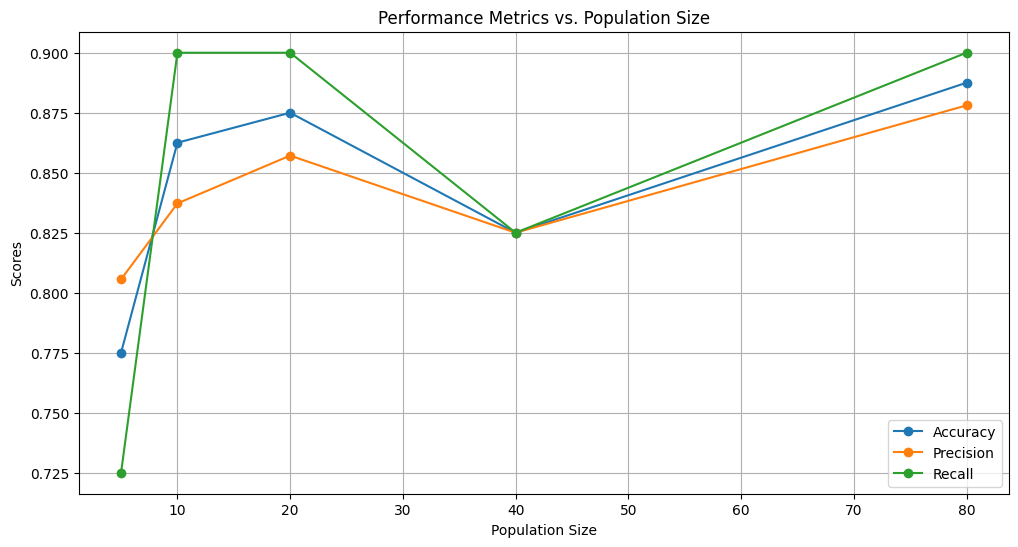

In [55]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(results_df["Population Size"], results_df["Average Accuracy"], marker='o', label='Accuracy')
plt.plot(results_df["Population Size"], results_df["Average Precision"], marker='o', label='Precision')
plt.plot(results_df["Population Size"], results_df["Average Recall"], marker='o', label='Recall')
plt.xlabel('Population Size')
plt.ylabel('Scores')
plt.title('Performance Metrics vs. Population Size')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# Define parameters for PSO optimization
n_particles = 80
inertia_weight_range = np.linspace(0.1, 1, num=10)
global_weight = 0.3
local_weight = 0.6

results = []

tfidf_model = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tfidf_model.fit_transform(X_train)
X_test_tfidf = tfidf_model.transform(X_test)

X_train_dense = X_train_tfidf.toarray()

for inertia in inertia_weight_range:
    selected_features = pso_feature_selection(X_train_dense, y_train, n_particles, inertia, global_weight, local_weight, MultinomialNB)

    if not np.any(selected_features):
        selected_features[0] = True

    nb = NaiveBayes(MultinomialNB)
    nb.fit(X_train_tfidf, y_train, selected_features)
    y_pred = nb.predict(X_test_tfidf.toarray(), selected_features)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    fold_results = {
        "Inertia Weight": inertia,
        "Average Accuracy": accuracy,
        "Average Precision": precision,
        "Average Recall": recall
    }

    results.append(fold_results)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Inertia Weight", "Average Accuracy"], ascending=[True, False])

print(results_df.to_string(index=False))
results_df.to_csv("inertia.csv")

 Inertia Weight  Average Accuracy  Average Precision  Average Recall
            0.1            0.8500           0.850000           0.850
            0.2            0.8250           0.809524           0.850
            0.3            0.8000           0.852941           0.725
            0.4            0.8500           0.850000           0.850
            0.5            0.8125           0.804878           0.825
            0.6            0.8375           0.813953           0.875
            0.7            0.8250           0.809524           0.850
            0.8            0.7875           0.794872           0.775
            0.9            0.8750           0.826087           0.950
            1.0            0.8000           0.800000           0.800


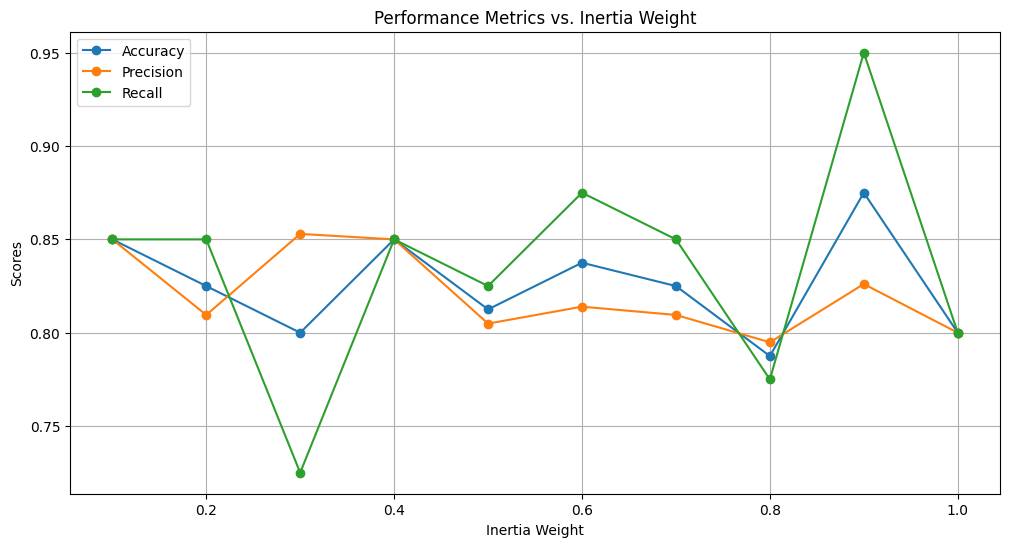

In [66]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(results_df["Inertia Weight"], results_df["Average Accuracy"], marker='o', label='Accuracy')
plt.plot(results_df["Inertia Weight"], results_df["Average Precision"], marker='o', label='Precision')
plt.plot(results_df["Inertia Weight"], results_df["Average Recall"], marker='o', label='Recall')
plt.xlabel('Inertia Weight')
plt.ylabel('Scores')
plt.title('Performance Metrics vs. Inertia Weight')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Define parameters for PSO optimization
n_particles = 80
inertia = 0.9
global_best_weight_range = np.linspace(0.1, 1, num=10)
local_weight = 0.6

results = []

tfidf_model = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tfidf_model.fit_transform(X_train)
X_test_tfidf = tfidf_model.transform(X_test)

X_train_dense = X_train_tfidf.toarray()

for global_weight in global_best_weight_range:
    selected_features = pso_feature_selection(X_train_dense, y_train, n_particles, inertia, global_weight, local_weight, MultinomialNB)

    if not np.any(selected_features):
        selected_features[0] = True

    nb = NaiveBayes(MultinomialNB)
    nb.fit(X_train_tfidf, y_train, selected_features)
    y_pred = nb.predict(X_test_tfidf.toarray(), selected_features)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    fold_results = {
        "Global Best Weight": global_weight,
        "Average Accuracy": accuracy,
        "Average Precision": precision,
        "Average Recall": recall
    }

    results.append(fold_results)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Global Best Weight", "Average Accuracy"], ascending=[True, False])

print(results_df.to_string(index=False))
results_df.to_csv("global_weight.csv")

 Global Best Weight  Average Accuracy  Average Precision  Average Recall
                0.1            0.8875           0.860465           0.925
                0.2            0.8625           0.837209           0.900
                0.3            0.8000           0.833333           0.750
                0.4            0.9000           0.880952           0.925
                0.5            0.8125           0.777778           0.875
                0.6            0.8125           0.804878           0.825
                0.7            0.8500           0.818182           0.900
                0.8            0.8500           0.818182           0.900
                0.9            0.8750           0.857143           0.900
                1.0            0.8500           0.804348           0.925


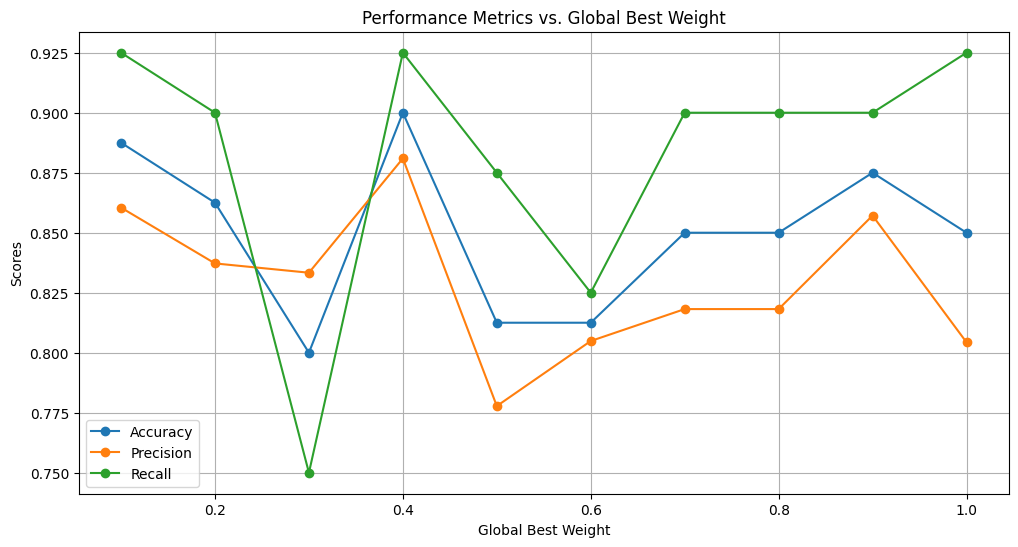

In [68]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(results_df["Global Best Weight"], results_df["Average Accuracy"], marker='o', label='Accuracy')
plt.plot(results_df["Global Best Weight"], results_df["Average Precision"], marker='o', label='Precision')
plt.plot(results_df["Global Best Weight"], results_df["Average Recall"], marker='o', label='Recall')
plt.xlabel('Global Best Weight')
plt.ylabel('Scores')
plt.title('Performance Metrics vs. Global Best Weight')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# Define parameters for PSO optimization
n_particles = 80
inertia = 0.9
global_weight = 0.4
local_best_weight_range = np.linspace(0.1, 1, num=10)

results = []

tfidf_model = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tfidf_model.fit_transform(X_train)
X_test_tfidf = tfidf_model.transform(X_test)

X_train_dense = X_train_tfidf.toarray()

for local_weight in local_best_weight_range:
    selected_features = pso_feature_selection(X_train_dense, y_train, n_particles, inertia, global_weight, local_weight, MultinomialNB)

    if not np.any(selected_features):
        selected_features[0] = True

    nb = NaiveBayes(MultinomialNB)
    nb.fit(X_train_tfidf, y_train, selected_features)
    y_pred = nb.predict(X_test_tfidf.toarray(), selected_features)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    fold_results = {
        "Local Best Weight": local_weight,
        "Average Accuracy": accuracy,
        "Average Precision": precision,
        "Average Recall": recall
    }

    results.append(fold_results)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Local Best Weight", "Average Accuracy"], ascending=[True, False])

print(results_df.to_string(index=False))
results_df.to_csv("local_weight.csv")

 Local Best Weight  Average Accuracy  Average Precision  Average Recall
               0.1            0.8500           0.818182           0.900
               0.2            0.8875           0.844444           0.950
               0.3            0.8500           0.804348           0.925
               0.4            0.7625           0.769231           0.750
               0.5            0.8250           0.809524           0.850
               0.6            0.8500           0.833333           0.875
               0.7            0.8875           0.860465           0.925
               0.8            0.8000           0.772727           0.850
               0.9            0.8625           0.822222           0.925
               1.0            0.8375           0.800000           0.900


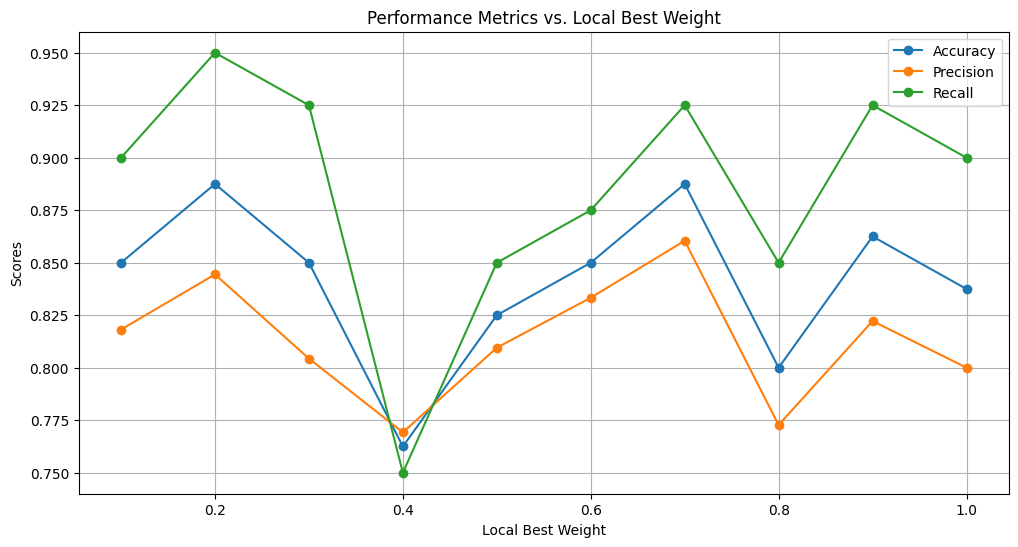

In [70]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(results_df["Local Best Weight"], results_df["Average Accuracy"], marker='o', label='Accuracy')
plt.plot(results_df["Local Best Weight"], results_df["Average Precision"], marker='o', label='Precision')
plt.plot(results_df["Local Best Weight"], results_df["Average Recall"], marker='o', label='Recall')
plt.xlabel('Local Best Weight')
plt.ylabel('Scores')
plt.title('Performance Metrics vs. Local Best Weight')
plt.legend()
plt.grid(True)
plt.show()